---
### 1. Importing modules.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sb

import scipy.stats as scistats

---
### 2. Importing preprocessed data.

In [2]:
mod_train_data = pd.read_csv('mod_train_data.csv')
mod_valid_data = pd.read_csv('mod_valid_data.csv')
mod_test_data = pd.read_csv('mod_test_data.csv')

y_train = pd.read_csv('y_train.csv').values.ravel()
y_valid = pd.read_csv('y_valid.csv').values.ravel()

print('Training data:', mod_train_data.shape)
print('Training target:', y_train.shape)
print('Valid data:', mod_valid_data.shape)
print('Valid target:', y_valid.shape)
print('Test data:', mod_test_data.shape)

Training data: (709, 956)
Training target: (709,)
Valid data: (179, 956)
Valid target: (179,)
Test data: (418, 956)


---
### 3. Developing models.

In [26]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import accuracy_score

---
#### 3.1. Selecting best model.

In [16]:
seed = 0

lrclf = LogisticRegression()
sgdclf = SGDClassifier()
nbclf = GaussianNB()
dtclf = DecisionTreeClassifier(random_state = seed)
rfclf = RandomForestClassifier(random_state = seed)
gbclf = GradientBoostingClassifier(random_state = seed)
svclf = SVC()
knnclf = KNeighborsClassifier()

In [17]:
classifiers = [lrclf, sgdclf, nbclf, dtclf, rfclf, gbclf, svclf, knnclf]

model_df = {}

for classifier in classifiers:
    clf_scores = cross_val_score(classifier, X = mod_train_data, y = y_train, 
                                 cv = 10)
    model_df[classifier] = np.round(clf_scores.mean(), 4)

In [66]:
df = pd.DataFrame(data = list(model_df.values()), index = model_df.keys(), 
                  columns = ['Score']).sort_values('Score', ascending = False)
df

,Score
GradientBoostingClassifier(random_state=0),0.8392
RandomForestClassifier(random_state=0),0.8364
LogisticRegression(),0.8351
SVC(),0.8308
KNeighborsClassifier(),0.8252
DecisionTreeClassifier(random_state=0),0.8124
SGDClassifier(),0.8011
GaussianNB(),0.4668


Choosing the top 3 Machine Learning algotithm for developing the model.

##### 3.1.1 Logistic Regression.

In [68]:
# Checking whether changing the threshold can improve the model's accuracy.

lrclf = LogisticRegression(random_state = 0)

cvp_res = cross_val_predict(lrclf, mod_train_data, y_train, cv = 10,
                            method = 'predict_proba')

In [70]:
from sklearn.metrics import precision_recall_curve

In [71]:
precisions, recalls, thresholds = precision_recall_curve(y_train, cvp_res[:, 0])

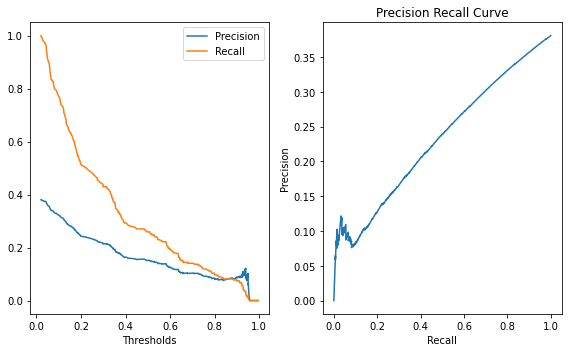

In [78]:
plt.figure(figsize = (8, 5))
plt.subplot(121)
plt.plot(thresholds, precisions[: -1], label = 'Precision')
plt.plot(thresholds, recalls[: -1], label = 'Recall')
plt.xlabel('Thresholds')
plt.legend()

plt.subplot(122)
plt.plot(recalls[: -1], precisions[: -1])
plt.title('Precision Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.tight_layout()
plt.show()

Threshold cannot be used for improvement.

In [94]:
def overfit_tuning(classifier):
    '''This function takes classifier as the input and prints 
       the scores for training and validation data.
       
       Input: Classifier
       Output: prints the scores
    '''
    
    classifier.fit(X = mod_train_data, y = y_train)
    
    pred_train = classifier.predict(mod_train_data)
    pred_valid = classifier.predict(mod_valid_data)
    
    print('Training data')
    print('-------------')
    print('Accuracy:', np.round(accuracy_score(y_true = y_train, 
                                               y_pred = pred_train), 4))
    print('Precision:', np.round(precision_score(y_true = y_train, 
                                                 y_pred = pred_train, 
                                                 average = 'macro'), 4))
    print('Recall:', np.round(recall_score(y_true = y_train, 
                                           y_pred = pred_train,
                                           average = 'macro'), 4))
    
    
    print('\nValidation data')
    print('-----------------')
    print('Accuracy:', np.round(accuracy_score(y_true = y_valid, 
                                               y_pred = pred_valid), 4))
    print('Precision:', np.round(precision_score(y_true = y_valid, 
                                                 y_pred = pred_valid,
                                                 average = 'macro'), 4))
    print('Recall:', np.round(recall_score(y_true = y_valid, 
                                           y_pred = pred_valid,
                                           average = 'macro'), 4))

In [95]:
# Seed value.

seed = 0

In [96]:
# Checking the model's scores on validation data.

# 1) Logistic model

lrclf = LogisticRegression(random_state = seed)
overfit_tuning(lrclf)

Training data
-------------
Accuracy: 0.8928
Precision: 0.8932
Recall: 0.8778

Validation data
-----------------
Accuracy: 0.8212
Precision: 0.8169
Recall: 0.8005


In [97]:
# 2) Random Forest model

rfclf = RandomForestClassifier(random_state = seed)
overfit_tuning(rfclf)

Training data
-------------
Accuracy: 1.0
Precision: 1.0
Recall: 1.0

Validation data
-----------------
Accuracy: 0.8212
Precision: 0.8337
Recall: 0.787


In [98]:
# 3) GradientBoost model

gbclf = GradientBoostingClassifier(random_state = seed)
overfit_tuning(gbclf)

Training data
-------------
Accuracy: 0.8646
Precision: 0.8634
Recall: 0.8465

Validation data
-----------------
Accuracy: 0.8156
Precision: 0.8172
Recall: 0.7879


Choosing Random Forest model as it has better values on the validation data.

---
#### 3.2. Tuning the Random Forest Model.

In [102]:
from sklearn.model_selection import GridSearchCV

In [112]:
def manual_tuning(classifier, verbose = 0):
    '''This function is used in conjunction with for loop for finding
       the optimal parameters.
       
       Input: Classifier
       Output: Tuples of scores'''
    
    gb_res = classifier.fit(X = mod_train_data, y = y_train)
    
    pred_train = classifier.predict(mod_train_data)
    pred_valid = classifier.predict(mod_valid_data)

    train_acc = np.round(accuracy_score(y_true = y_train, 
                                        y_pred = pred_train), 4)
    train_pre = np.round(precision_score(y_true = y_train, 
                                         y_pred = pred_train, 
                                         average = 'macro'), 4)
    train_rec = np.round(recall_score(y_true = y_train, 
                                      y_pred = pred_train,
                                      average = 'macro'), 4)
    
    valid_acc = np.round(accuracy_score(y_true = y_valid, 
                                        y_pred = pred_valid), 4)
    valid_pre = np.round(precision_score(y_true = y_valid, 
                                         y_pred = pred_valid,
                                         average = 'macro'), 4)
    valid_rec = np.round(recall_score(y_true = y_valid, 
                                      y_pred = pred_valid,
                                      average = 'macro'), 4)
    
    if verbose:
        print('Training data')
        print('Accuracy:', train_acc)
        print('Precision:', train_pre)
        print('Recall:', train_rec)


        print('\nValidation data')
        print('Accuracy:', valid_acc)
        print('Precision:', valid_pre)
        print('Recall:', valid_rec)
    
    return (train_acc, valid_acc), (train_pre, valid_pre), (train_rec, valid_rec)

In [113]:
n_estimators_ = [30, 50, 60]
max_depth_ = [15, 20, 30]
min_samples_split_ = [5, 7, 9]

esti_used = []
accuracies_data = []
precisions_data = []
recalls_data = []

for estimator in n_estimators_:
    for depth in max_depth_:
        for min_split in min_samples_split_:
            esti_used.append((estimator, depth, min_split))
            
            rfclf = RandomForestClassifier(n_estimators = estimator, 
                                           max_depth = depth,
                                           min_samples_split = min_split,
                                           random_state = seed)
            accuracies, precisions, recalls = manual_tuning(rfclf, verbose = 0)
            accuracies_data.append(accuracies)
            precisions_data.append(precisions)
            recalls_data.append(recalls)

In [159]:
def all_plots():
    '''This function plots the Accuracy, Precision and Recall'''
    plt.figure(figsize = (8, 8))
    plt.subplot(311)
    plt.title('Accuracies')
    plt.plot(list(zip(*accuracies_data))[0], label = 'Training accuracy')
    plt.plot(list(zip(*accuracies_data))[1], label = 'Validation accuracy')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(312)
    plt.title('Precisions')
    plt.plot(list(zip(*precisions_data))[0], label = 'Training precision')
    plt.plot(list(zip(*precisions_data))[1], label = 'Validation precision')
    plt.xlabel('Iterations')
    plt.ylabel('Precisions')
    plt.legend()

    plt.subplot(313)
    plt.title('Recalls')
    plt.plot(list(zip(*recalls_data))[0], label = 'Training recall')
    plt.plot(list(zip(*recalls_data))[1], label = 'Validation recall')
    plt.xlabel('Iterations')
    plt.ylabel('Recalls')
    plt.legend()
    plt.tight_layout()
    plt.show()
    

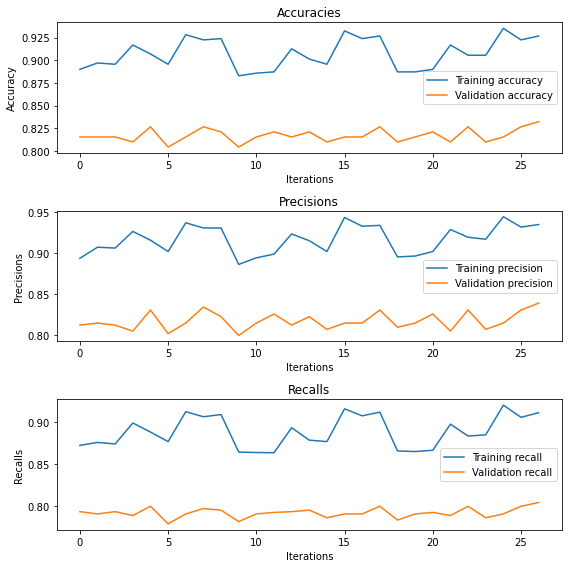

In [160]:
all_plots()

In [136]:
def all_scatter():
    '''This function plots the Accuracy, Precision and Recall'''
    plt.scatter(list(zip(*accuracies_data))[0],
                list(zip(*accuracies_data))[1], label = 'Accuracy')
    plt.scatter(list(zip(*precisions_data))[0],
                list(zip(*precisions_data))[1], label = 'Precision')
    plt.scatter(list(zip(*recalls_data))[0],
                list(zip(*recalls_data))[1], label = 'Recall')
    plt.xlabel('Training values')
    plt.ylabel('Valid values')
    plt.legend()
    plt.tight_layout()
    plt.show()

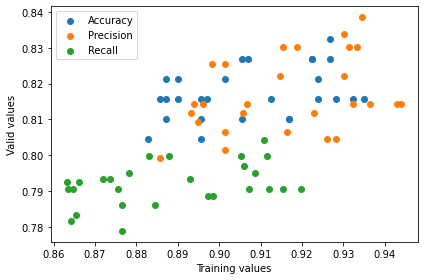

In [137]:
all_scatter()

In [170]:
def max_values_(accuracies_data, precisions_data, recalls_data):
    '''This function finds the max scores from the validation values.'''
    print('Max values')
    print('Acc:', max(list(zip(*accuracies_data))[1]), 
          '\nPre:', max(list(zip(*precisions_data))[1]),
          '\nRec:', max(list(zip(*recalls_data))[1]))

In [171]:
max_values_(accuracies_data, precisions_data, recalls_data)

Max values
Acc: 0.8324 
Pre: 0.8386 
Rec: 0.8042


In [ ]:
# Validation data Previous values
# -------------------------------
# Accuracy: 0.8212
# Precision: 0.8337
# Recall: 0.787

In [175]:
def max_params_(accuracies_data, precisions_data, recalls_data):
    '''This function finds the parameters corresponding to max scores from the 
       validation values.'''
    max_index_acc = list(zip(*accuracies_data))[1].index(max(list(zip(*accuracies_data))[1]))
    print('Estimator based on max val accuracy:', esti_used[max_index_acc])

    max_index_prec = list(zip(*precisions_data))[1].index(max(list(zip(*precisions_data))[1]))
    print('Estimator based on max val precision:', esti_used[max_index_prec])

    max_index_rec = list(zip(*recalls_data))[1].index(max(list(zip(*recalls_data))[1]))
    print('Estimator based on max val recall:', esti_used[max_index_rec])

In [176]:
max_params_(accuracies_data, precisions_data, recalls_data)

Estimator based on max val accuracy: (60, 30, 9)
Estimator based on max val precision: (60, 30, 9)
Estimator based on max val recall: (60, 30, 9)


In [177]:
# Improvement observed.

In [178]:
# Further tuning

n_estimators_ = [60, 70, 80]
max_depth_ = [30, 40, 50]
min_samples_split_ = [9, 11, 13]

esti_used = []
accuracies_data = []
precisions_data = []
recalls_data = []

for estimator in n_estimators_:
    for depth in max_depth_:
        for min_split in min_samples_split_:
            esti_used.append((estimator, depth, min_split))
            
            rfclf = RandomForestClassifier(n_estimators = estimator, 
                                           max_depth = depth,
                                           min_samples_split = min_split,
                                           random_state = seed)
            accuracies, precisions, recalls = manual_tuning(rfclf, verbose = 0)
            accuracies_data.append(accuracies)
            precisions_data.append(precisions)
            recalls_data.append(recalls)

In [182]:
max_params_(accuracies_data, precisions_data, recalls_data)

Estimator based on max val accuracy: (60, 30, 13)
Estimator based on max val precision: (60, 30, 13)
Estimator based on max val recall: (60, 30, 13)


In [181]:
max_values_(accuracies_data, precisions_data, recalls_data)

Max values
Acc: 0.838 
Pre: 0.8432 
Rec: 0.8115


In [ ]:
# Validation data Previous values
# -------------------------------
# Max values
# Acc: 0.8324 
# Pre: 0.8386 
# Rec: 0.8042

In [ ]:
# Improvement observed.

In [191]:
# Further tuning

min_samples_leaf = [1, 3, 10]
max_features = ['sqrt', 'auto', 'log2']

esti_used = []
accuracies_data = []
precisions_data = []
recalls_data = []

for min_sample in min_samples_leaf:
    for max_feat in max_features:
        esti_used.append((min_sample, max_feat))

        rfclf = RandomForestClassifier(n_estimators = 60, 
                                       max_depth = 30,
                                       min_samples_split = 13,
                                       min_samples_leaf = min_sample,
                                       max_features = max_feat,
                                       random_state = seed)
        accuracies, precisions, recalls = manual_tuning(rfclf, verbose = 0)
        accuracies_data.append(accuracies)
        precisions_data.append(precisions)
        recalls_data.append(recalls)

C:\Users\praja\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\praja\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\praja\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\praja\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

In [192]:
max_params_(accuracies_data, precisions_data, recalls_data)

Estimator based on max val accuracy: (1, 'log2')
Estimator based on max val precision: (1, 'log2')
Estimator based on max val recall: (1, 'log2')


In [193]:
max_values_(accuracies_data, precisions_data, recalls_data)

Max values
Acc: 0.8436 
Pre: 0.8561 
Rec: 0.8133


In [ ]:
# Validation data Previous values
# -------------------------------
# Max values
# Acc: 0.838 
# Pre: 0.8432 
# Rec: 0.8115

In [ ]:
# Improvement observed

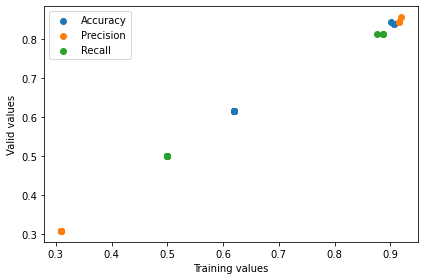

In [194]:
all_scatter()

In [195]:
# Further tuning

bootstrap_ = [True, False]
warm_start_ = [True, False]
ccp_alpha_ = [0.010, 0.015, 0.020, 0.025]

esti_used = []
accuracies_data = []
precisions_data = []
recalls_data = []

for strap in bootstrap_:
    for start in warm_start_:
        for ccp_ in ccp_alpha_:
            esti_used.append((strap, start, ccp_))

            rfclf = RandomForestClassifier(n_estimators = 60, 
                                           max_depth = 30,
                                           min_samples_split = 13,
                                           min_samples_leaf = 1,
                                           max_features = 'log2',
                                           bootstrap = strap,
                                           warm_start = start,
                                           ccp_alpha = ccp_,
                                           random_state = seed)
            accuracies, precisions, recalls = manual_tuning(rfclf, verbose = 0)
            accuracies_data.append(accuracies)
            precisions_data.append(precisions)
            recalls_data.append(recalls)

C:\Users\praja\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\praja\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\praja\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\praja\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

In [196]:
max_params_(accuracies_data, precisions_data, recalls_data)

Estimator based on max val accuracy: (True, True, 0.01)
Estimator based on max val precision: (True, True, 0.01)
Estimator based on max val recall: (True, True, 0.01)


In [197]:
max_values_(accuracies_data, precisions_data, recalls_data)

Max values
Acc: 0.7486 
Pre: 0.8219 
Rec: 0.6793


In [198]:
# No improvements

---
### 4. Final model.

In [203]:
rfclf = RandomForestClassifier(n_estimators = 60, 
                               max_depth = 30,
                               min_samples_split = 13,
                               min_samples_leaf = 1,
                               max_features = 'log2',
                               bootstrap = True,
                               warm_start = True,
                               ccp_alpha = 0.0,
                               random_state = seed)

accuracies, precisions, recalls = manual_tuning(rfclf, verbose = False)
accuracies_data.append(accuracies)
precisions_data.append(precisions)
recalls_data.append(recalls)

In [204]:
max_values_(accuracies_data, precisions_data, recalls_data)

Max values
Acc: 0.8436 
Pre: 0.8561 
Rec: 0.8133


---
### 5. Predictions.

In [205]:
# Test data predictions.

id_test = pd.read_csv('test.csv')

pred_test = rfclf.predict(X = mod_test_data)

test_df = pd.DataFrame({'PassengerId': id_test['PassengerId'],
                        'Survived': pred_test})
test_df.to_csv('3rdattempt.csv', index = False)

---
### 6. Kaggle Submissions.

In [208]:
pd.DataFrame(data = [[0.7822, 8741], 
                     [0.78947, 4248],
                     [0.79904, 2495]], 
             index = ['First_attempt', 'Second_attempt', 'Third_attempt'], 
             columns = ['Score', 'Rank'])

,Score,Rank
First_attempt,0.78220,8741
Second_attempt,0.78947,4248
Third_attempt,0.79904,2495
